# Corrective RAG (CRAG) and Self-RAG for the Djezzy Chatbot Project

Self-RAG allows the model to self-assess in real time the relevance and reliability of its responses, using internal reasoning before providing them to the customer.

Corrective-RAG, on the other hand, incorporates a mechanism of self-reflection / self-grading on the retrieved documents: the system analyzes and scores the quality of the passages found, then corrects or repeats the search if the sources are deemed insufficient. In cases where relevant documents are lacking, CRAG performs a targeted web search to enrich the information and ensure more comprehensive results.

By merging these two methods, the Djezzy chatbot benefits from dual control: first over the relevance of the extracted documents, and then over the coherence and reliability of the final response. This improves accuracy, customer satisfaction, and reduces escalations to the call center.





## Setup

First, let's download our required packages and set our API keys

In [1]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python langchain_chroma pypdf google-search-results

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import getpass
import os

os.environ["SERPAPI_API_KEY"]  = "..."

# Définir la clé API dans les variables d’environnement
os.environ["OPENAI_API_KEY"] = "..."


In [3]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, END

from typing_extensions import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

In [4]:
llm = ChatOpenAI(
    model="gpt-4o", temperature = 0) # I want to minimize hallucination - temperature = 0 makes the model output more deterministic

# Our Embedding Model - has to also be compatible with the LLM
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings



In [6]:

import pypdf
from langchain.text_splitter import CharacterTextSplitter

In [7]:
from langchain_community.document_loaders import PyPDFLoader

In [8]:



pdf_path = "A-propos-de-Djezzy.pdf"


# Safety measure I have put for debugging purposes :)
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"PDF file not found: {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path) # This loads the PDF

# Checks if the PDF is there
try:
    pages = pdf_loader.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
except Exception as e:
    print(f"Error loading PDF: {e}")
    raise

# Chunking Process
text_splitter = CharacterTextSplitter(
    separator="separatoor",
    is_separator_regex=False,
    # Utilisez le séparateur de votre choix
    chunk_size=200,
    chunk_overlap=0
)


pages_split = text_splitter.split_documents(pages) # We now apply this to our pages

persist_directory = r"C\Agents"
collection_name = "stock_market"

# If our collection does not exist in the directory, we create using the os command
if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)


try:
    # Here, we actually create the chroma database using our embeddigns model
    vectorstore = Chroma.from_documents(
        documents=pages_split,
        embedding=embeddings,
        persist_directory=persist_directory,
        collection_name=collection_name
    )
    print(f"Created ChromaDB vector store!")

except Exception as e:
    print(f"Error setting up ChromaDB: {str(e)}")
    raise


# Now we create our retriever
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5} # K is the amount of chunks to return
)




PDF has been loaded and has 51 pages
Created ChromaDB vector store!


## LLMs

In [9]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "djezzy legend"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1893: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  

binary_score='yes'


In [12]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# https://smith.langchain.com/hub/efriis/self-rag-hallucination-grader
hallucination_prompt = hub.pull("efriis/self-rag-hallucination-grader")

hallucination_grader = hallucination_prompt | structured_llm_grader
print(generation)
hallucination_grader.invoke({"documents": docs, "generation": generation})

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1893: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


The Djezzy Legend offer provides a variety of mobile packages tailored to different needs and financial constraints. These packages range from a premium 2500 DA recharge offering 100 GB of internet and unlimited national calls to a budget-friendly 50 DA recharge for quick connectivity. Each package is designed to align with customers' financial parameters and usage requirements.


GradeHallucinations(binary_score='yes')

In [13]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
answer_prompt = hub.pull("efriis/self-rag-answer-grader")

answer_grader = answer_prompt | structured_llm_grader
print(question)
print(generation)
answer_grader.invoke({"question": question, "generation": generation})

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1893: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


djezzy legend
The Djezzy Legend offer provides a variety of mobile packages tailored to different needs and financial constraints. These packages range from a premium 2500 DA recharge offering 100 GB of internet and unlimited national calls to a budget-friendly 50 DA recharge for quick connectivity. Each package is designed to align with customers' financial parameters and usage requirements.


GradeAnswer(binary_score='yes')

In [11]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


The Djezzy Legend offer provides a variety of mobile packages tailored to different needs and financial constraints. These packages range from a premium 2500 DA recharge offering 100 GB of internet and unlimited national calls to a budget-friendly 50 DA recharge for quick connectivity. Each package is designed to align with customers' financial parameters and usage requirements.


In [14]:
### Question Re-writer

# LLM


# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning.\n
     When rewriting, always adapt the query to focus on Djezzy (the Algerian telecommunications company),
     its mobile offers, internet packages, customer service, promotions, and technical support.\n
    Ensure the rewritten question contains relevant Djezzy-specific keywords to improve search accuracy.
 """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the benefits and features of the Djezzy Legend mobile plan?'

In [15]:
system = """The previous answer did not fully address the user's question.
Please rewrite the original question below to be clearer, more specific, and easier to answer.
Keep the original intent and meaning but improve it so that relevant information can be found more easily.
 """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the original question: \n\n {question} \n ",
        ),
    ]
)

question_rewriter_selfrag = re_write_prompt | llm | StrOutputParser()
question_rewriter_selfrag.invoke({"question": question})

'Could you provide more information about the "Djezzy Legend" service? Specifically, I would like to know what it offers, its benefits, and any relevant details about how to subscribe or use it.'

## Web Search Tool

In [16]:
from langchain_community.utilities import SerpAPIWrapper
web_search_tool = SerpAPIWrapper()


## Create Graph

Now let's create our graph that will use CRAG

### Define Graph State

In [17]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
       Represents the current state of the graph.

       Attributes:
       question (str): The user's question.
       generation (str): The response generated by the LLM.
       web_search (str): Flag indicating whether a web search should be performed.
       documents (list): A collection of retrieved documents.
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [18]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query_web(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def transform_query_selfrag(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter_selfrag.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    system ="""If the input question is already in French, do not translate it. Otherwise, translate the following question into French, preserving its original meaning exactly:"""
    prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n traduction .",
        ),
    ]
)


    chain = prompt | llm
    question1=chain.invoke({"question": question}).content

    print(question1)
    # Web search
    docs = web_search_tool.run(question1)
    #docs = web_search_tool.invoke({"query": question})
    web_results =docs
    print(len(docs))
    print(web_results)
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":

        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Edges



def Halluination_AND_generation_V_question (state):
    """
          Evaluates whether the generated response is supported by the provided document and addresses the question.

          Args:
          state (dict): The current state of the graph.

          Returns:
          str: The name of the next node to execute.
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    print(generation)
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Compile Graph

The just follows the flow we outlined in the figure above.

In [19]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(GraphState)

# Define the nodes
graph.add_node("retrieve", retrieve)  # retrieve
graph.add_node("grade_documents", grade_documents)  # grade documents
graph.add_node("generate", generate)  # generate
graph.add_node("transform_query", transform_query_web)
graph.add_node("transform_query_selfrag", transform_query_selfrag)
graph.add_node("web_search", web_search)  # web search

# Build graph
graph.add_edge(START, "retrieve")
graph.add_edge("retrieve", "grade_documents")
graph.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
graph.add_edge("transform_query", "web_search")
graph.add_edge("transform_query_selfrag", "generate")
graph.add_edge("web_search", "generate")
graph.add_conditional_edges(
    "generate",
    Halluination_AND_generation_V_question ,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query_selfrag",
    },
)


# Compile
app = graph.compile()

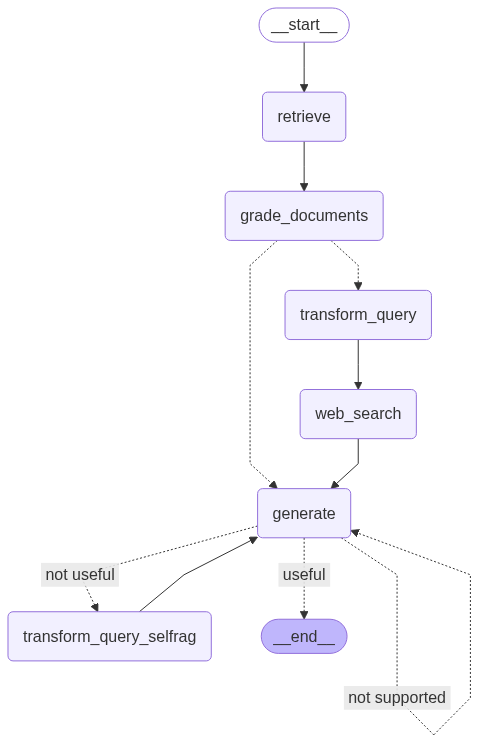

In [20]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use the graph

In [22]:
from pprint import pprint

# Run
inputs = {"question": "give steps to benifit the   PROMO INTERNET X2 offer of djezzy "}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
Quelles sont les étapes pour profiter de l'offre PROMO INTERNET X2 de Djezzy ?
306
Pour en bénéficier : composez *707# ou souscrivez via la DJEZZY App. Pour plus de détails, plusieurs possibilités s'offrent à vous : visitez le site web Djezzy, appelez le centre d'appel disponible 24H/24, rapprochez-vous d'un des centres de service ou contactez Djezzy via ses canaux digitaux disponibles.
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
To take advantage of Djezzy's PROMO INTERNET X2 offer, dia